In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [3]:
dataset = Path('datasets/sfm_South-Building/')
images = dataset / 'South-Building/images/'

outputs = Path('outputs/sfm/')
sfm_pairs = outputs / 'pairs-exhaustive.txt'  # exhaustive matching
sfm_dir = outputs / 'sfm_superpoint+superglue'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

features = feature_conf['output']
feature_file = f"{features}.h5"
match_file = f"{features}_{matcher_conf['output']}_{sfm_pairs.stem}.h5"

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data, and refined with SfM.

In [3]:
%%bash -s "$dataset"
wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1
unzip datasets/South-Building.zip -d $1

--2020-10-10 16:34:42--  http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip
Resolving cvg.ethz.ch (cvg.ethz.ch)... 129.132.85.27
Connecting to cvg.ethz.ch (cvg.ethz.ch)|129.132.85.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230948942 (220M) [application/zip]
Saving to: ‘datasets/sfm_South-Building/South-Building.zip’

     0K .......... .......... .......... .......... ..........  0% 98.9K 37m59s
    50K .......... .......... .......... .......... ..........  0%  216K 27m41s
   100K .......... .......... .......... .......... ..........  0% 4.57M 18m43s
   150K .......... .......... .......... .......... ..........  0%  224K 18m13s
   200K .......... .......... .......... .......... ..........  0% 5.17M 14m43s
   250K .......... .......... .......... .......... ..........  0% 5.28M 12m23s
   300K .......... .......... .......... .......... ..........  0%  264K 12m38s
   350K .......... .......... .......... .......... ..........  0% 

CalledProcessError: Command 'b'wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1\nunzip datasets/South-Building.zip -d $1\n'' returned non-zero exit status 9.

## Extract local features

In [5]:
extract_features.main(feature_conf, images, outputs)

[10/14/2020 09:44:23 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
Loaded SuperPoint model
[10/14/2020 09:44:23 INFO] Found 128 images in root datasets/sfm_South-Building/South-Building/images.


100%|██████████| 128/128 [00:09<00:00, 13.66it/s]

[10/14/2020 09:44:33 INFO] Finished exporting features.


## Exhaustive matching
Since the dataset is small, we can match all $\frac{n(n-1)}{2}$ images pairs. To do so, we pass the argument `exhaustive=True` and make sure that the pair file does not exist yet. If your dataset is larger, exhaustive matching might take a long time - consider selecting fewer pairs using image retrieval and `hloc/pairs_from_retrieval.py`.

In [6]:
match_features.main(matcher_conf, sfm_pairs, features, outputs, exhaustive=True)

[10/14/2020 09:45:06 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[10/14/2020 09:45:06 INFO] Writing exhaustive match pairs to outputs/sfm/pairs-exhaustive.txt.


  0%|          | 0/32640 [00:00<?, ?it/s]

Loaded SuperGlue model ("outdoor" weights)


KeyError: 'Unable to open object (component not found)'

## SfM reconstruction
Run COLMAP on the features and matches.

In [7]:
reconstruction.main(
    sfm_dir,
    images,
    sfm_pairs,
    outputs / feature_file,
    outputs / match_file)

[10/10/2020 19:22:13 INFO] Creating an empty database...
[10/10/2020 19:22:13 INFO] Importing images into the database...
[10/10/2020 19:22:20 INFO] Importing features into the database...


100%|██████████| 128/128 [00:00<00:00, 1218.69it/s]


[10/10/2020 19:22:20 INFO] Importing matches into the database...


100%|██████████| 8128/8128 [00:02<00:00, 3287.95it/s]


[10/10/2020 19:22:24 INFO] Performing geometric verification of the matches...
[10/10/2020 19:23:55 INFO] Running the 3D reconstruction...
[10/10/2020 19:23:55 INFO] colmap mapper --database_path outputs/sfm/sfm_superpoint+superglue/database.db --image_path datasets/sfm_South-Building/South-Building/images --output_path outputs/sfm/sfm_superpoint+superglue/models --Mapper.num_threads 16
[10/10/2020 19:30:01 INFO] Reconstructed 1 models.
[10/10/2020 19:30:01 INFO] Largest model is #0 with {largest_model_num_images} images.
[10/10/2020 19:30:01 INFO] Statistics:
{'mean_reproj_error': 1.389522,
 'mean_track_length': 4.618821,
 'num_input_images': 128,
 'num_observations': 241629,
 'num_observations_per_image': 1887.726562,
 'num_reg_images': 128,
 'num_sparse_points': 52314}


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

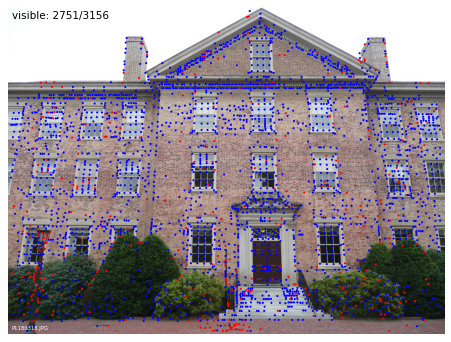

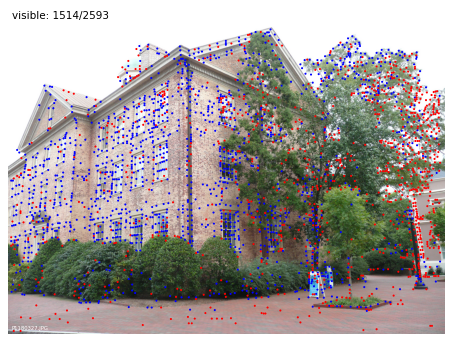

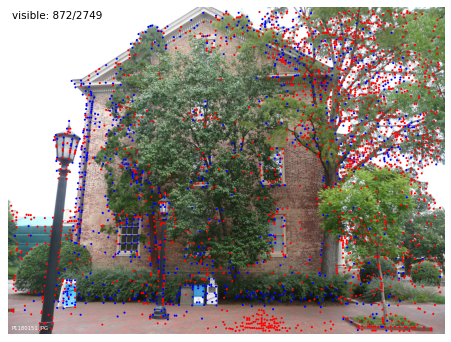

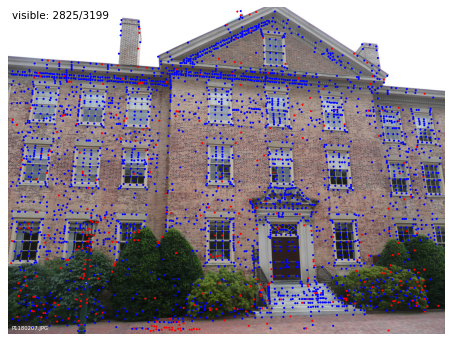

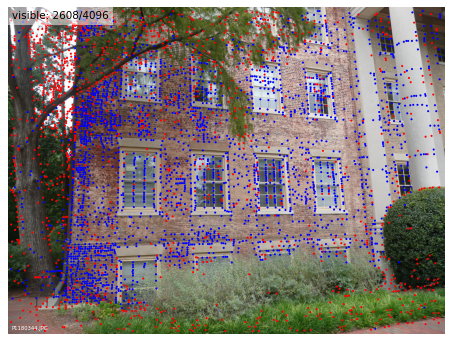

In [8]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='visibility', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='track_length', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='depth', n=5)